In [3]:
import json
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import BertTokenizer

# Path to the JSON file
json_path = '/kaggle/input/combined-landscape-captions/combined_landscape_captions.json'

# Load JSON data
with open(json_path, 'r') as f:
    data = json.load(f)

# Verify the number of samples
print(f"Total samples: {len(data)}")

Total samples: 14319


In [4]:
class LandscapeDataset(Dataset):
    def __init__(self, data, image_transform=None, tokenizer=None, max_length=128):
        self.image_paths = list(data.keys())
        self.captions = list(data.values())
        self.image_transform = image_transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        caption = self.captions[idx]
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None

        if self.image_transform:
            image = self.image_transform(image)
        
        # Tokenize caption
        if self.tokenizer:
            encoding = self.tokenizer.encode_plus(
                caption,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt',
            )
            input_ids = encoding['input_ids'].squeeze()  # Shape: (max_length)
            attention_mask = encoding['attention_mask'].squeeze()  # Shape: (max_length)
        else:
            input_ids = torch.tensor(0)
            attention_mask = torch.tensor(0)

        return {
            'image': image,                  # Tensor: (3, H, W)
            'input_ids': input_ids,          # Tensor: (max_length)
            'attention_mask': attention_mask,  # Tensor: (max_length)
            'caption': caption
        }

In [5]:
# Image transformations
image_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # You can adjust the size based on your model's requirements
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  # Normalizing between -1 and 1
                         std=[0.5, 0.5, 0.5]),
])

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
# Create the dataset
dataset = LandscapeDataset(data, image_transform=image_transform, tokenizer=tokenizer)

# Remove None samples if any
dataset = [sample for sample in dataset if sample is not None]

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32  # Adjust based on your GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [7]:
import torch.nn as nn

# Text embedding dimension
embedding_dim = 256

# Create text encoder (we can use a simple embedding layer for this example)
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(TextEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, embed_dim, batch_first=True)
    
    def forward(self, input_ids):
        x = self.embedding(input_ids)
        _, (hidden, _) = self.lstm(x)
        return hidden.squeeze(0)  # Shape: (batch_size, embed_dim)

In [8]:
class Generator(nn.Module):
    def __init__(self, noise_dim, embed_dim, feature_maps=64):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.embed_dim = embed_dim

        self.fc = nn.Sequential(
            nn.Linear(noise_dim + embed_dim, feature_maps * 8 * 4 * 4),
            nn.BatchNorm1d(feature_maps * 8 * 4 * 4),
            nn.ReLU(True),
        )

        self.deconv = nn.Sequential(
            # Input: (feature_maps * 8) x 4 x 4
            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1),  # 32x32
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps, 3, 4, 2, 1),  # 64x64
            nn.Tanh(),
        )

    def forward(self, noise, text_embedding):
        x = torch.cat((noise, text_embedding), dim=1)  # Shape: (batch_size, noise_dim + embed_dim)
        x = self.fc(x)
        x = x.view(-1, 512, 4, 4)
        img = self.deconv(x)
        return img  # Shape: (batch_size, 3, 64, 64)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, embed_dim, feature_maps=64):
        super(Discriminator, self).__init__()
        self.feature_maps = feature_maps  # Store feature_maps as an instance variable

        self.conv = nn.Sequential(
            # Input: (3) x 64 x 64
            nn.Conv2d(3, self.feature_maps, 4, 2, 1),  # 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.feature_maps, self.feature_maps * 2, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(self.feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.feature_maps * 2, self.feature_maps * 4, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(self.feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.feature_maps * 4, self.feature_maps * 8, 4, 2, 1),  # 4x4
            nn.BatchNorm2d(self.feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.text_projection = nn.Linear(embed_dim, self.feature_maps * 8 * 4 * 4)
        self.output = nn.Sequential(
            nn.Conv2d(self.feature_maps * 8, 1, 4),
            nn.Sigmoid()
        )

    def forward(self, img, text_embedding):
        x_img = self.conv(img)  # Shape: (batch_size, feature_maps * 8, 4, 4)
        x_text = self.text_projection(text_embedding)  # Shape: (batch_size, feature_maps * 8 * 4 * 4)
        x_text = x_text.view(-1, self.feature_maps * 8, 4, 4)  # Use self.feature_maps

        # Element-wise addition
        x = x_img + x_text

        out = self.output(x).view(-1)
        return out  # Shape: (batch_size)

In [10]:
import torch.optim as optim

# Initialize models
vocab_size = tokenizer.vocab_size
text_encoder = TextEncoder(vocab_size, embedding_dim)
generator = Generator(noise_dim=100, embed_dim=embedding_dim)
discriminator = Discriminator(embed_dim=embedding_dim, feature_maps=64)

# Move models to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
text_encoder = text_encoder.to(device)
generator = generator.to(device)
discriminator = discriminator.to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
lr = 0.0002
beta1 = 0.5
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_TE = optim.Adam(text_encoder.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_gan(train_loader, text_encoder, generator, discriminator, 
              optimizer_G, optimizer_D, optimizer_TE, criterion, device, epochs=50):
    for epoch in range(epochs):
        generator.train()
        discriminator.train()
        text_encoder.train()

        total_d_loss = 0
        total_g_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            batch_size = images.size(0)

            # Generate labels
            real_labels = torch.ones(batch_size).to(device)
            fake_labels = torch.zeros(batch_size).to(device)

            # Train Text Encoder and get text embeddings
            optimizer_TE.zero_grad()
            text_embeddings = text_encoder(input_ids)

            # Train Discriminator
            optimizer_D.zero_grad()

            # Real images
            real_outputs = discriminator(images, text_embeddings)
            d_loss_real = criterion(real_outputs, real_labels)
            
            # Fake images
            noise = torch.randn(batch_size, 100).to(device)
            with torch.no_grad():
                fake_images = generator(noise, text_embeddings.detach())
            
            fake_outputs = discriminator(fake_images.detach(), text_embeddings.detach())
            d_loss_fake = criterion(fake_outputs, fake_labels)
            
            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward(retain_graph=True)
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            
            # Regenerate fake images with gradient flow
            noise = torch.randn(batch_size, 100).to(device)
            fake_images = generator(noise, text_embeddings)
            g_outputs = discriminator(fake_images, text_embeddings)
            g_loss = criterion(g_outputs, real_labels)
            g_loss.backward()
            optimizer_G.step()

            # Optionally update text encoder
            optimizer_TE.step()

            # Accumulate losses
            total_d_loss += d_loss.item()
            total_g_loss += g_loss.item()

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss D: {total_d_loss/len(train_loader):.4f}, Avg Loss G: {total_g_loss/len(train_loader):.4f}")

        # Save models after each epoch
        torch.save(generator.state_dict(), f'generator_epoch_{epoch+1}.pth')
        torch.save(discriminator.state_dict(), f'discriminator_epoch_{epoch+1}.pth')
        torch.save(text_encoder.state_dict(), f'text_encoder_epoch_{epoch+1}.pth')

# Usage in main training script
train_gan(train_loader, text_encoder, generator, discriminator, 
          optimizer_G, optimizer_D, optimizer_TE, criterion, device, epochs=50)

Epoch 1/50: 100%|██████████| 358/358 [00:32<00:00, 10.85it/s]


Epoch [1/50], Avg Loss D: 0.6825, Avg Loss G: 5.7370


Epoch 2/50: 100%|██████████| 358/358 [00:32<00:00, 10.94it/s]


Epoch [2/50], Avg Loss D: 0.9759, Avg Loss G: 2.5453


Epoch 3/50: 100%|██████████| 358/358 [00:34<00:00, 10.43it/s]


Epoch [3/50], Avg Loss D: 0.6980, Avg Loss G: 3.5442


Epoch 4/50: 100%|██████████| 358/358 [00:36<00:00,  9.94it/s]


Epoch [4/50], Avg Loss D: 0.6378, Avg Loss G: 3.7289


Epoch 5/50: 100%|██████████| 358/358 [00:35<00:00, 10.06it/s]


Epoch [5/50], Avg Loss D: 0.5922, Avg Loss G: 3.8798


Epoch 6/50: 100%|██████████| 358/358 [00:35<00:00, 10.10it/s]


Epoch [6/50], Avg Loss D: 0.5680, Avg Loss G: 3.8960


Epoch 7/50: 100%|██████████| 358/358 [00:35<00:00, 10.05it/s]


Epoch [7/50], Avg Loss D: 0.5233, Avg Loss G: 4.1256


Epoch 8/50: 100%|██████████| 358/358 [00:35<00:00, 10.07it/s]


Epoch [8/50], Avg Loss D: 0.5583, Avg Loss G: 4.0998


Epoch 9/50: 100%|██████████| 358/358 [00:35<00:00, 10.06it/s]


Epoch [9/50], Avg Loss D: 0.5440, Avg Loss G: 3.9945


Epoch 10/50: 100%|██████████| 358/358 [00:35<00:00, 10.03it/s]


Epoch [10/50], Avg Loss D: 0.5490, Avg Loss G: 4.0067


Epoch 11/50: 100%|██████████| 358/358 [00:35<00:00, 10.05it/s]


Epoch [11/50], Avg Loss D: 0.5229, Avg Loss G: 4.1868


Epoch 12/50: 100%|██████████| 358/358 [00:35<00:00, 10.10it/s]


Epoch [12/50], Avg Loss D: 0.5047, Avg Loss G: 4.1194


Epoch 13/50: 100%|██████████| 358/358 [00:35<00:00, 10.09it/s]


Epoch [13/50], Avg Loss D: 0.4941, Avg Loss G: 4.2694


Epoch 14/50: 100%|██████████| 358/358 [00:35<00:00, 10.08it/s]


Epoch [14/50], Avg Loss D: 0.4672, Avg Loss G: 4.2469


Epoch 15/50: 100%|██████████| 358/358 [00:35<00:00, 10.08it/s]


Epoch [15/50], Avg Loss D: 0.4509, Avg Loss G: 4.3839


Epoch 16/50: 100%|██████████| 358/358 [00:35<00:00, 10.07it/s]


Epoch [16/50], Avg Loss D: 0.4586, Avg Loss G: 4.3132


Epoch 17/50: 100%|██████████| 358/358 [00:35<00:00, 10.05it/s]


Epoch [17/50], Avg Loss D: 0.4502, Avg Loss G: 4.5440


Epoch 18/50: 100%|██████████| 358/358 [00:35<00:00, 10.04it/s]


Epoch [18/50], Avg Loss D: 0.4714, Avg Loss G: 4.5330


Epoch 19/50: 100%|██████████| 358/358 [00:35<00:00, 10.05it/s]


Epoch [19/50], Avg Loss D: 0.4210, Avg Loss G: 4.5249


Epoch 20/50: 100%|██████████| 358/358 [00:35<00:00, 10.08it/s]


Epoch [20/50], Avg Loss D: 0.3900, Avg Loss G: 4.7001


Epoch 21/50: 100%|██████████| 358/358 [00:35<00:00, 10.08it/s]


Epoch [21/50], Avg Loss D: 0.4670, Avg Loss G: 4.5644


Epoch 22/50: 100%|██████████| 358/358 [00:35<00:00, 10.07it/s]


Epoch [22/50], Avg Loss D: 0.3987, Avg Loss G: 4.8012


Epoch 23/50: 100%|██████████| 358/358 [00:35<00:00, 10.06it/s]


Epoch [23/50], Avg Loss D: 0.4203, Avg Loss G: 4.5072


Epoch 24/50: 100%|██████████| 358/358 [00:35<00:00, 10.06it/s]


Epoch [24/50], Avg Loss D: 0.3786, Avg Loss G: 4.9013


Epoch 25/50: 100%|██████████| 358/358 [00:35<00:00, 10.07it/s]


Epoch [25/50], Avg Loss D: 0.2879, Avg Loss G: 4.8662


Epoch 26/50: 100%|██████████| 358/358 [00:35<00:00, 10.08it/s]


Epoch [26/50], Avg Loss D: 0.4480, Avg Loss G: 5.1971


Epoch 27/50: 100%|██████████| 358/358 [00:35<00:00, 10.07it/s]


Epoch [27/50], Avg Loss D: 0.3598, Avg Loss G: 5.0996


Epoch 28/50: 100%|██████████| 358/358 [00:35<00:00, 10.08it/s]


Epoch [28/50], Avg Loss D: 0.2494, Avg Loss G: 5.1247


Epoch 29/50: 100%|██████████| 358/358 [00:35<00:00, 10.08it/s]


Epoch [29/50], Avg Loss D: 0.4027, Avg Loss G: 5.5355


Epoch 30/50: 100%|██████████| 358/358 [00:35<00:00, 10.10it/s]


Epoch [30/50], Avg Loss D: 0.2929, Avg Loss G: 5.0491


Epoch 31/50: 100%|██████████| 358/358 [00:35<00:00, 10.10it/s]


Epoch [31/50], Avg Loss D: 0.3664, Avg Loss G: 5.1484


Epoch 32/50: 100%|██████████| 358/358 [00:35<00:00, 10.10it/s]


Epoch [32/50], Avg Loss D: 0.3158, Avg Loss G: 5.3362


Epoch 33/50: 100%|██████████| 358/358 [00:35<00:00, 10.09it/s]


Epoch [33/50], Avg Loss D: 0.2333, Avg Loss G: 5.3793


Epoch 34/50: 100%|██████████| 358/358 [00:35<00:00, 10.09it/s]


Epoch [34/50], Avg Loss D: 0.3643, Avg Loss G: 5.2101


Epoch 35/50: 100%|██████████| 358/358 [00:35<00:00, 10.08it/s]


Epoch [35/50], Avg Loss D: 0.3103, Avg Loss G: 5.1785


Epoch 36/50: 100%|██████████| 358/358 [00:35<00:00, 10.08it/s]


Epoch [36/50], Avg Loss D: 0.2956, Avg Loss G: 5.3247


Epoch 37/50: 100%|██████████| 358/358 [00:35<00:00, 10.10it/s]


Epoch [37/50], Avg Loss D: 0.3423, Avg Loss G: 5.2236


Epoch 38/50: 100%|██████████| 358/358 [00:35<00:00, 10.09it/s]


Epoch [38/50], Avg Loss D: 0.2513, Avg Loss G: 5.2771


Epoch 39/50: 100%|██████████| 358/358 [00:35<00:00, 10.11it/s]


Epoch [39/50], Avg Loss D: 0.3041, Avg Loss G: 5.4304


Epoch 40/50: 100%|██████████| 358/358 [00:35<00:00, 10.10it/s]


Epoch [40/50], Avg Loss D: 0.2690, Avg Loss G: 5.5183


Epoch 41/50: 100%|██████████| 358/358 [00:35<00:00, 10.11it/s]


Epoch [41/50], Avg Loss D: 0.2300, Avg Loss G: 5.4916


Epoch 42/50: 100%|██████████| 358/358 [00:35<00:00, 10.11it/s]


Epoch [42/50], Avg Loss D: 0.2589, Avg Loss G: 5.6519


Epoch 43/50: 100%|██████████| 358/358 [00:35<00:00, 10.10it/s]


Epoch [43/50], Avg Loss D: 0.3269, Avg Loss G: 5.4399


Epoch 44/50: 100%|██████████| 358/358 [00:35<00:00, 10.09it/s]


Epoch [44/50], Avg Loss D: 0.1704, Avg Loss G: 5.8528


Epoch 45/50: 100%|██████████| 358/358 [00:35<00:00, 10.09it/s]


Epoch [45/50], Avg Loss D: 0.3169, Avg Loss G: 5.8190


Epoch 46/50: 100%|██████████| 358/358 [00:35<00:00, 10.09it/s]


Epoch [46/50], Avg Loss D: 0.2440, Avg Loss G: 5.5057


Epoch 47/50: 100%|██████████| 358/358 [00:35<00:00, 10.09it/s]


Epoch [47/50], Avg Loss D: 0.2554, Avg Loss G: 5.6835


Epoch 48/50: 100%|██████████| 358/358 [00:35<00:00, 10.09it/s]


Epoch [48/50], Avg Loss D: 0.1992, Avg Loss G: 5.8872


Epoch 49/50: 100%|██████████| 358/358 [00:35<00:00, 10.11it/s]


Epoch [49/50], Avg Loss D: 0.3668, Avg Loss G: 5.4000


Epoch 50/50: 100%|██████████| 358/358 [00:35<00:00, 10.13it/s]

Epoch [50/50], Avg Loss D: 0.2710, Avg Loss G: 5.8229


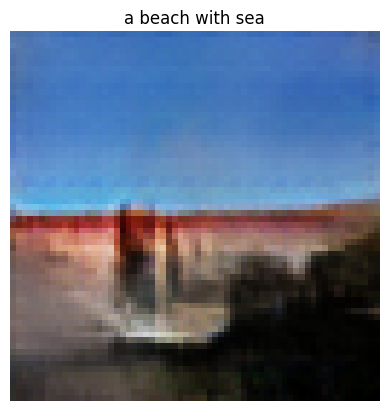

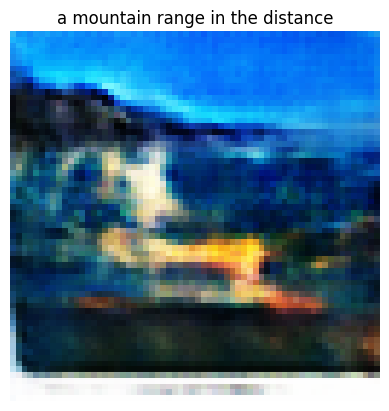

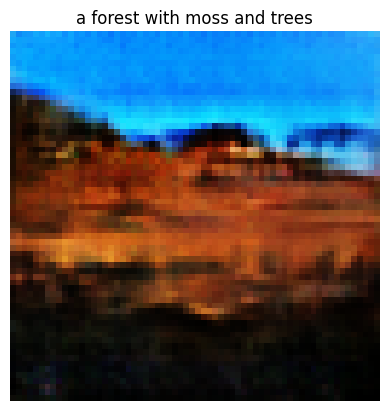

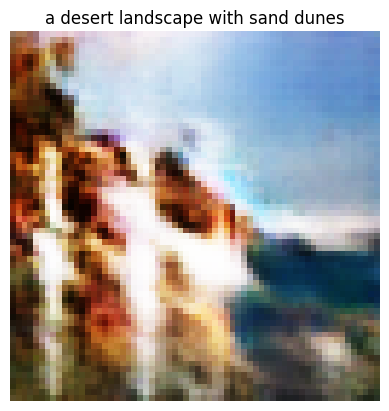

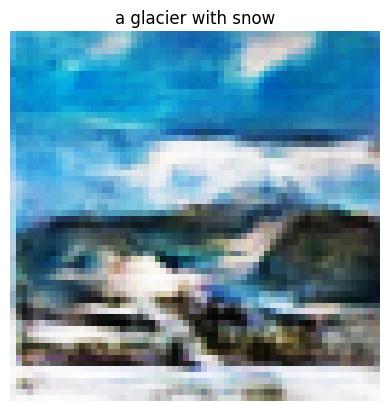

In [19]:
import matplotlib.pyplot as plt

def generate_images(generator, text_encoder, tokenizer, text_list, device, noise_dim=100):
    generator.eval()
    text_encoder.eval()

    with torch.no_grad():
        for text in text_list:
            # Tokenize text
            encoding = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt',
            )
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            # Get text embedding
            text_embedding = text_encoder(input_ids)  # Shape: (1, embed_dim)

            # Generate noise
            noise = torch.randn(1, noise_dim).to(device)

            # Generate image
            fake_image = generator(noise, text_embedding)
            fake_image = fake_image.squeeze(0)
            fake_image = (fake_image * 0.5) + 0.5  # Denormalize to [0,1]
            fake_image = fake_image.cpu().permute(1, 2, 0).numpy()

            # Display image
            plt.imshow(fake_image)
            plt.title(text)
            plt.axis('off')
            plt.show()

# Example usage
sample_texts = [
    "a beach with sea",
    "a mountain range in the distance",
    "a forest with moss and trees",
    "a desert landscape with sand dunes",
    "a glacier with snow"
]

generate_images(generator, text_encoder, tokenizer, sample_texts, device)